# TASK 1

In [4]:
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from matplotlib import cm
from tqdm import tqdm
from numpy import linalg as LA

import urllib
from urllib.error import HTTPError
from deap import tools

%matplotlib inline


In [5]:
# Sphere function (minimum at 0)
def objective_function_F1(X):
    return - np.sum(X**2, axis=1)

# Sphere function - modified


def objective_function_F1a(X):
    return - (X[:, 0]**2 + 9*X[:, 1]**2)

# Sphere function - modified


def objective_function_F1b(X):
    return - (X[:, 0]**2 + 625*X[:, 1]**2)

# Sphere function - modified


def objective_function_F1c(X):
    return - (X[:, 0]**2 + 2*X[:, 1]**2 - 2 * X[:, 0] * X[:, 1])


# Rastrigin function (minimum at 0)
def objective_function_F6(X):
    return - 10.0 * X.shape[1] - np.sum(X**2, axis=1) + 10.0 * np.sum(np.cos(2 * np.pi * X), axis=1)


# Schwefel function (minimum at 420.9687)
# (REMARK: should be considered only on [-500, 500]^d, because there are better minima outside)
def objective_function_F7(X):
    return - 418.9829 * X.shape[1] + np.sum(X * np.sin(np.sqrt(np.abs(X))), axis=1)


# Griewank function (minimum at 0)
def objective_function_F8(X):
    return - 1 - np.sum(X**2 / 4000, axis=1) + np.prod(np.cos(X / np.sqrt(np.linspace(1, X.shape[1], X.shape[1]))), axis=1)


In [6]:
def plot_3D_benchmark_function(objective_function, domain_X, domain_Y, title):
    plt.figure(figsize=(15, 10))
    ax = plt.gca(projection='3d')
    X, Y = np.meshgrid(domain_X, domain_Y)
    Z = - objective_function(np.vstack([X.ravel(),
                                        Y.ravel()]).T).reshape(X.shape[0], X.shape[1])
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                           cmap=cm.hot, linewidth=0, antialiased=True)
    plt.title(title)
    plt.show()


def plot_contour_benchmark_function(objective_function, domain_X, domain_Y, title):
    plt.figure(figsize=(9, 9))
    X, Y = np.meshgrid(domain_X, domain_Y)
    Z = - objective_function(np.vstack([X.ravel(),
                                        Y.ravel()]).T).reshape(X.shape[0], X.shape[1])
    plt.contour(X, Y, Z, 50)
    plt.title(title)
    plt.show()


In [7]:
def es(objective_function, chromosome_length, population_size, number_of_iterations, number_of_offspring, number_of_parents, sigma, tau, tau_0, log_frequency=1, low=-500, high=500):


    best_solution = np.empty((1, chromosome_length))
    best_solution_objective_value = 0.00

    log_objective_values = np.empty((number_of_iterations, 4))
    log_best_solutions = np.empty((number_of_iterations, chromosome_length))
    log_best_sigmas = np.empty((number_of_iterations, chromosome_length))

    # generating an initial population
    current_population_solutions = 100.0 * \
        np.random.rand(population_size, chromosome_length)
    current_population_sigmas = sigma * \
        np.ones((population_size, chromosome_length))

    # evaluating the objective function on the current population
    current_population_objective_values = objective_function(
        current_population_solutions)

    for t in range(number_of_iterations):
        current_population_solutions[current_population_solutions < low] = low
        current_population_solutions[current_population_solutions > high] = high
        # selecting the parent indices by the roulette wheel method
        fitness_values = current_population_objective_values - \
            current_population_objective_values.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / population_size * np.ones(population_size)

        parent_indices = np.random.choice(
            population_size,
            (number_of_offspring, number_of_parents),
            True,
            fitness_values
        ).astype(np.int64)

        # creating the children population by Global Intermediere Recombination
        children_population_solutions = np.zeros(
            (number_of_offspring, chromosome_length))
        children_population_sigmas = np.zeros(
            (number_of_offspring, chromosome_length))
        for i in range(number_of_offspring):
            children_population_solutions[i, :] = current_population_solutions[parent_indices[i, :], :].mean(
                axis=0)
            children_population_sigmas[i, :] = current_population_sigmas[parent_indices[i, :], :].mean(
                axis=0)

        # mutating the children population by adding random gaussian noise
        children_population_sigmas = children_population_sigmas \
            * np.exp(tau * np.random.randn(number_of_offspring, chromosome_length)
                     + tau_0 * np.random.randn(number_of_offspring, 1))

        children_population_solutions += children_population_sigmas * \
            np.random.randn(number_of_offspring, chromosome_length)

        # evaluating the objective function on the children population
        children_population_objective_values = objective_function(
            children_population_solutions)

        # replacing the current population by (Mu + Lambda) Replacement
        current_population_objective_values = np.hstack([
            current_population_objective_values,
            children_population_objective_values
        ])

        current_population_solutions = np.vstack(
            [current_population_solutions, children_population_solutions])
        current_population_sigmas = np.vstack(
            [current_population_sigmas, children_population_sigmas])

        I = np.argsort(current_population_objective_values)[::-1]
        current_population_solutions = current_population_solutions[I[:population_size], :]
        current_population_sigmas = current_population_sigmas[I[:population_size], :]
        current_population_objective_values = current_population_objective_values[
            I[:population_size]]

        # recording some statistics
        if best_solution_objective_value < current_population_objective_values[0]:
            best_solution = current_population_solutions[0, :]
            best_solution_objective_value = current_population_objective_values[0]
        log_objective_values[t, :] = [
            current_population_objective_values.min(),
            current_population_objective_values.max(),
            current_population_objective_values.mean(),
            current_population_objective_values.std()
        ]
        log_best_solutions[t, :] = current_population_solutions[0, :]
        log_best_sigmas[t, :] = current_population_sigmas[0, :]

        if np.mod(t+1, log_frequency) == 0:
            print("Iteration %04d : best score = %0.8f, mean score = %0.8f." % (
                t, log_objective_values[:t+1, 1].max(), log_objective_values[t, 2]))

    return best_solution_objective_value, best_solution, log_objective_values, log_best_solutions, log_best_sigmas


In [8]:
def run_es(d, N, T, objective_function, log_every=10, sigma=50.0):
    best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
        objective_function, d, N, T, 2*N, 2, sigma, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), log_every)

    plt.figure(figsize=(18, 4))
    plt.plot(history_objective_values[:, 0])
    plt.plot(history_objective_values[:, 1])
    plt.plot(history_objective_values[:, 2])
    plt.xlabel('iteration')
    plt.ylabel('value')
    plt.title('Objective function values')
    plt.legend(['Min', 'Mean', 'Max'], loc='upper right')
    plt.show()

    plt.figure(figsize=(18, 4))
    plt.plot(history_best_sigmas)
    plt.xlabel('iteration')
    plt.ylabel('sigma value')
    plt.title('best sigmas')
    plt.show()


# Sphere function

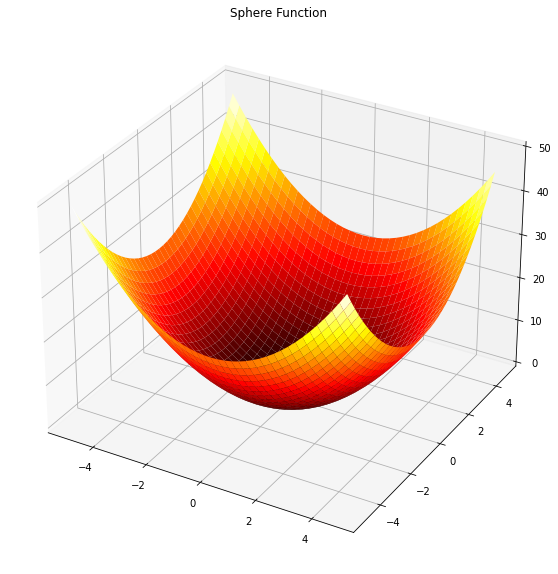

In [9]:
plot_3D_benchmark_function(objective_function_F1, np.arange(-5,
                                                            5, 0.25), np.arange(-5, 5, 0.25), 'Sphere Function')


D = 10
Iteration 0009 : best score = -80.59443554, mean score = -423.74831196.
Iteration 0019 : best score = -0.07629064, mean score = -1.25034572.
Iteration 0029 : best score = -0.00050064, mean score = -0.00271725.
Iteration 0039 : best score = -0.00000072, mean score = -0.00000540.
Iteration 0049 : best score = -0.00000000, mean score = -0.00000001.
Iteration 0059 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0069 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0079 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0089 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0099 : best score = -0.00000000, mean score = -0.00000000.


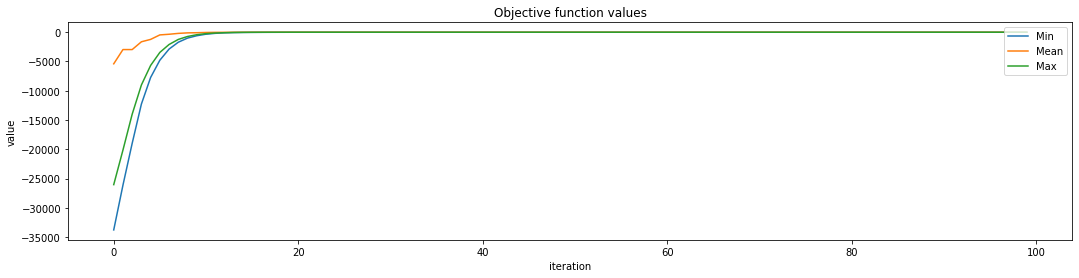

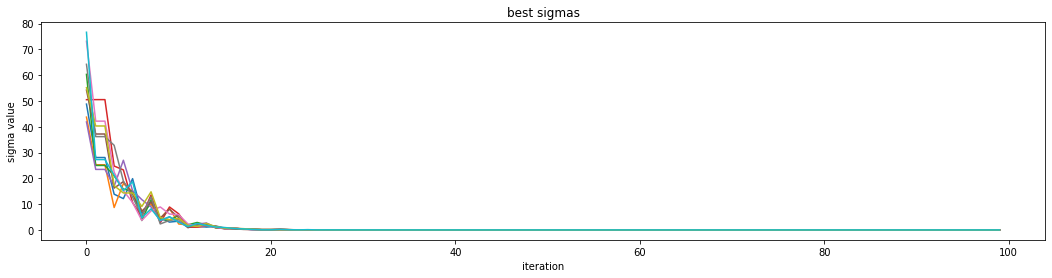

In [10]:
print("D = 10")
run_es(d=10, N=2000, T=100, objective_function=objective_function_F1, log_every=10)

D = 20
Iteration 0009 : best score = -1515.83629785, mean score = -3559.25498042.
Iteration 0019 : best score = -26.61136954, mean score = -93.62803226.
Iteration 0029 : best score = -0.92515785, mean score = -2.20138832.
Iteration 0039 : best score = -0.02094586, mean score = -0.05847517.
Iteration 0049 : best score = -0.00050796, mean score = -0.00143975.
Iteration 0059 : best score = -0.00001575, mean score = -0.00003527.
Iteration 0069 : best score = -0.00000039, mean score = -0.00000116.
Iteration 0079 : best score = -0.00000001, mean score = -0.00000003.
Iteration 0089 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0099 : best score = -0.00000000, mean score = -0.00000000.


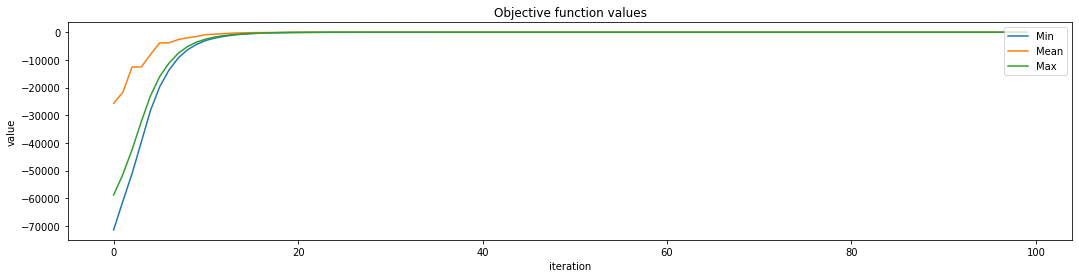

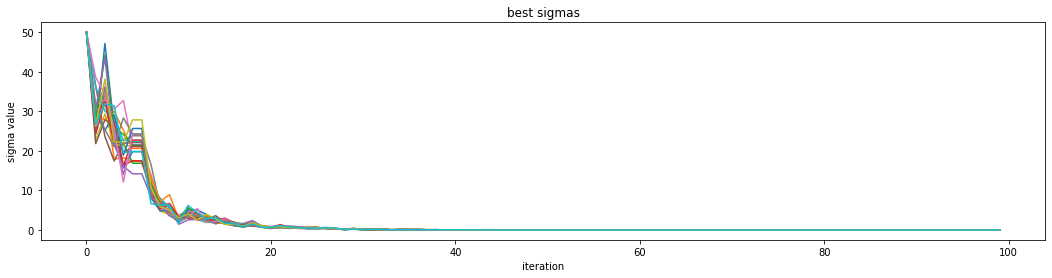

In [11]:
print("D = 20")
run_es(d=20, N=2000, T=100, objective_function=objective_function_F1, log_every=10)


D = 50
Iteration 0009 : best score = -24782.69775098, mean score = -35447.46692057.
Iteration 0019 : best score = -3961.89299834, mean score = -6129.31161383.
Iteration 0029 : best score = -823.57040457, mean score = -1282.30308857.
Iteration 0039 : best score = -206.70144480, mean score = -287.50018217.
Iteration 0049 : best score = -48.34812954, mean score = -65.63327746.
Iteration 0059 : best score = -11.62054505, mean score = -16.07486674.
Iteration 0069 : best score = -2.07555417, mean score = -3.48316652.
Iteration 0079 : best score = -0.55445611, mean score = -0.82652663.
Iteration 0089 : best score = -0.15317981, mean score = -0.20578772.
Iteration 0099 : best score = -0.03747658, mean score = -0.04941719.


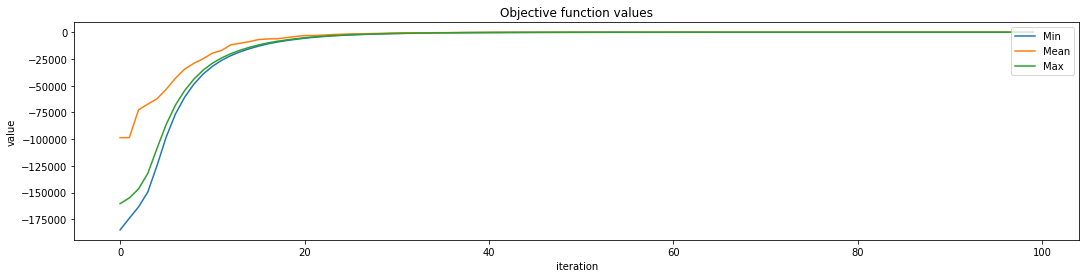

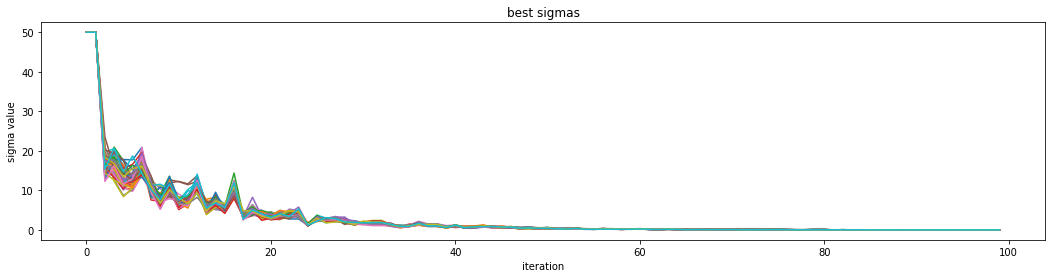

In [12]:
print("D = 50")
run_es(d=50, N=2000, T=100, objective_function=objective_function_F1, log_every=10)


D = 50
Iteration 0009 : best score = -22993.86487616, mean score = -37617.79023493.
Iteration 0019 : best score = -4259.80365054, mean score = -5991.24778660.
Iteration 0029 : best score = -888.46205925, mean score = -1297.92438672.
Iteration 0039 : best score = -187.53928357, mean score = -284.60927050.
Iteration 0049 : best score = -41.49863631, mean score = -59.61589381.
Iteration 0059 : best score = -10.20613551, mean score = -14.09384530.
Iteration 0069 : best score = -2.63752469, mean score = -3.58162442.
Iteration 0079 : best score = -0.65000669, mean score = -0.91247974.
Iteration 0089 : best score = -0.14215164, mean score = -0.20987467.
Iteration 0099 : best score = -0.03584243, mean score = -0.05287103.
Iteration 0109 : best score = -0.00981235, mean score = -0.01307839.
Iteration 0119 : best score = -0.00256219, mean score = -0.00349367.
Iteration 0129 : best score = -0.00055179, mean score = -0.00087468.
Iteration 0139 : best score = -0.00015733, mean score = -0.00021933.


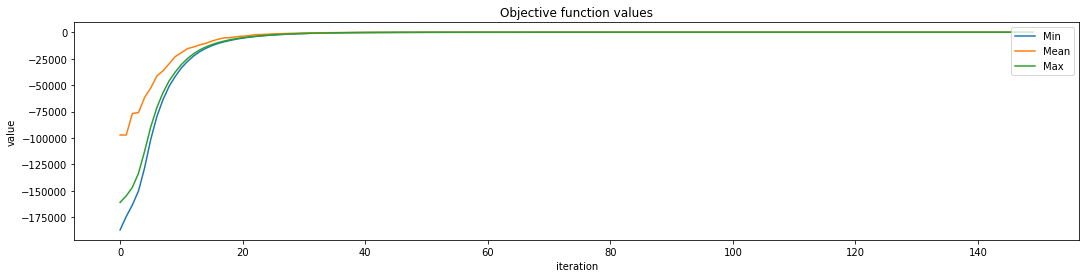

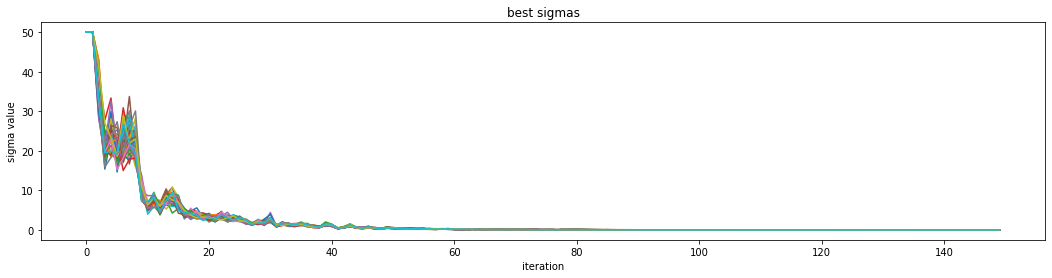

In [13]:
print("D = 50")
run_es(d=50, N=2000, T=150, objective_function=objective_function_F1, log_every=10)


D = 100
Iteration 0029 : best score = -20816.74519440, mean score = -24375.45862103.
Iteration 0059 : best score = -2476.67595517, mean score = -2898.23889033.
Iteration 0089 : best score = -313.19774145, mean score = -362.64258084.
Iteration 0119 : best score = -34.75696848, mean score = -42.66124432.
Iteration 0149 : best score = -4.88274396, mean score = -5.59499067.
Iteration 0179 : best score = -0.72881938, mean score = -0.85528540.
Iteration 0209 : best score = -0.11916799, mean score = -0.14079272.
Iteration 0239 : best score = -0.01791769, mean score = -0.02116225.
Iteration 0269 : best score = -0.00304948, mean score = -0.00352169.
Iteration 0299 : best score = -0.00044020, mean score = -0.00052348.


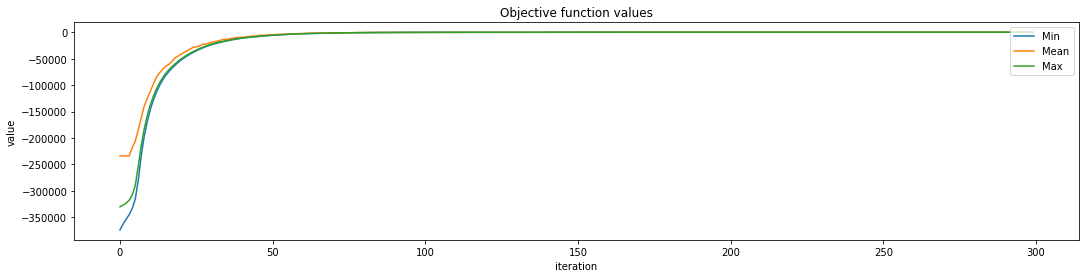

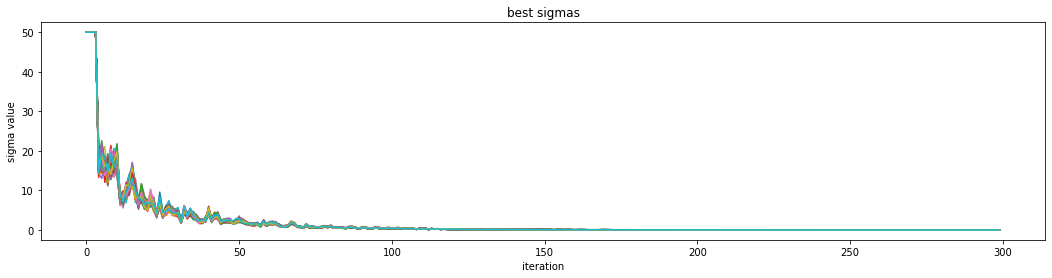

In [14]:
print("D = 100")
run_es(d=100, N=2000, T=300, objective_function=objective_function_F1, log_every=30)


# Rastrigin

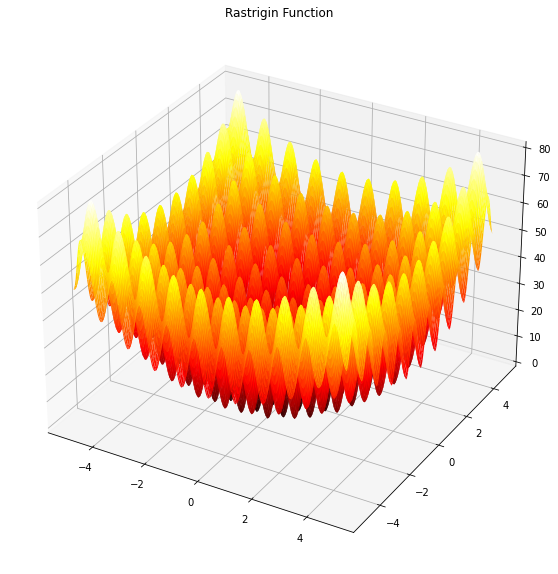

In [15]:
plot_3D_benchmark_function(objective_function_F6, np.arange(-5,
                                                            5, 0.05), np.arange(-5, 5, 0.05), 'Rastrigin Function')


d = 10
Iteration 0019 : best score = -29.70972856, mean score = -78.96311547.
Iteration 0039 : best score = -24.17033282, mean score = -55.97264882.
Iteration 0059 : best score = -0.04923672, mean score = -0.41747348.
Iteration 0079 : best score = -0.00000018, mean score = -0.00000168.
Iteration 0099 : best score = -0.00000000, mean score = -0.00000000.


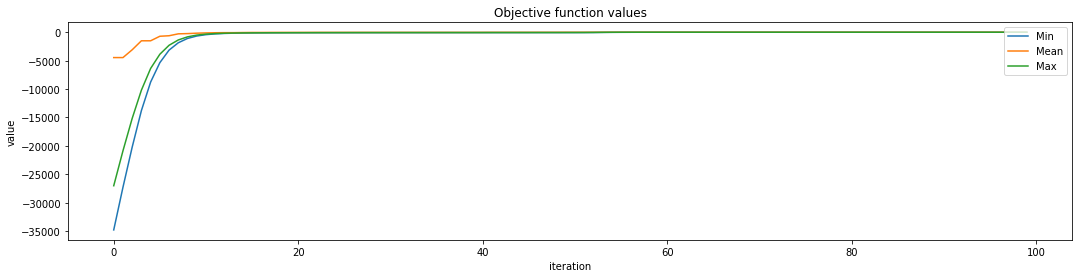

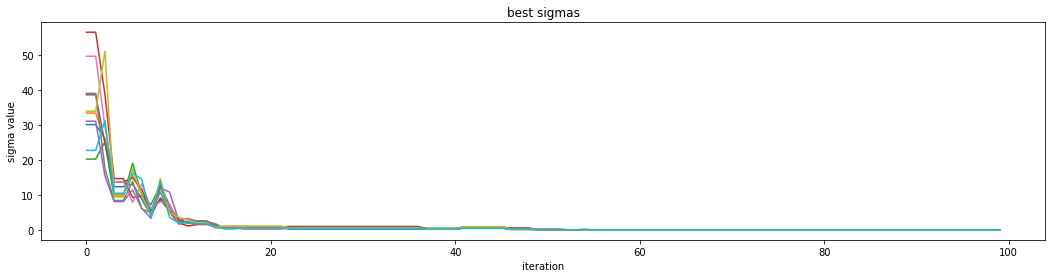

In [16]:
print("d = 10")
run_es(d=10, N=2000, T=100, objective_function=objective_function_F6, log_every=20)


d = 20
Iteration 0019 : best score = -155.82951779, mean score = -263.73997426.
Iteration 0039 : best score = -106.01647546, mean score = -155.12324618.
Iteration 0059 : best score = -77.02030989, mean score = -140.22171091.
Iteration 0079 : best score = -52.72620440, mean score = -83.69047046.
Iteration 0099 : best score = -15.95188327, mean score = -16.00802274.
Iteration 0119 : best score = -15.91935857, mean score = -15.91937924.
Iteration 0139 : best score = -15.91934492, mean score = -15.91934493.


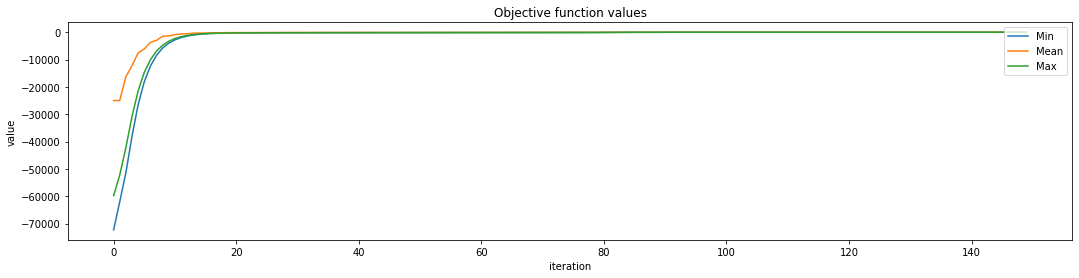

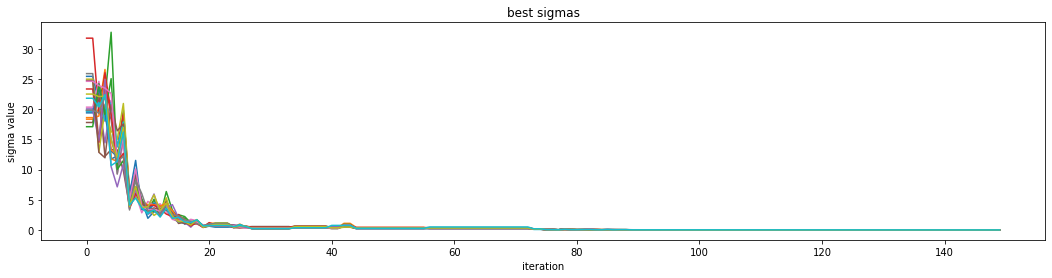

In [17]:
print("d = 20")
run_es(d=20, N=2000, T=150, objective_function=objective_function_F6, log_every=20)


d = 50
Iteration 0019 : best score = -4935.78059559, mean score = -6699.01733546.
Iteration 0039 : best score = -688.55851133, mean score = -861.62830471.
Iteration 0059 : best score = -447.89045957, mean score = -552.78113417.
Iteration 0079 : best score = -374.39032049, mean score = -489.82794153.
Iteration 0099 : best score = -127.86981445, mean score = -139.94673113.
Iteration 0119 : best score = -103.77432603, mean score = -104.51211607.
Iteration 0139 : best score = -102.52476111, mean score = -102.55281419.
Iteration 0159 : best score = -102.48332996, mean score = -102.48417790.
Iteration 0179 : best score = -102.48083885, mean score = -102.48090051.
Iteration 0199 : best score = -102.48070169, mean score = -102.48070542.
Iteration 0219 : best score = -102.48069304, mean score = -102.48069341.
Iteration 0239 : best score = -102.48069227, mean score = -102.48069229.
Iteration 0259 : best score = -102.48069220, mean score = -102.48069220.


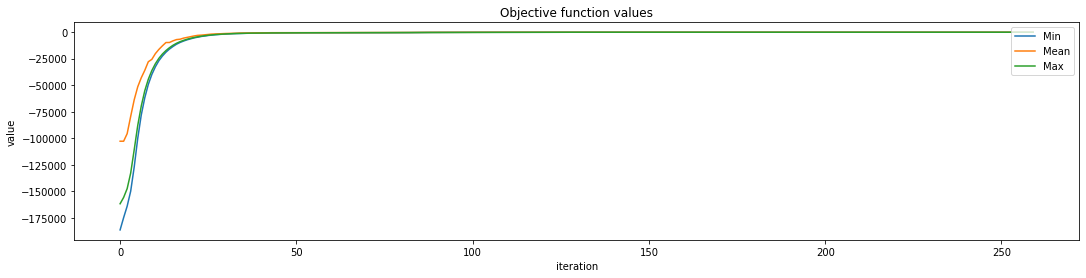

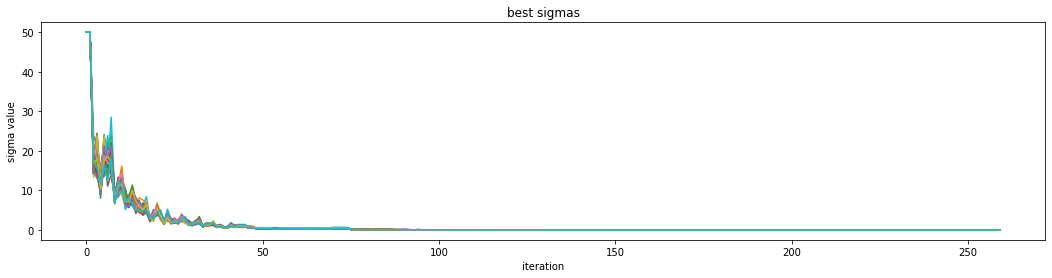

In [18]:
print("d = 50")
run_es(d=50, N=2000, T=260, objective_function=objective_function_F6, log_every=20)


d = 100
Iteration 0019 : best score = -49592.03568552, mean score = -56821.47810956.
Iteration 0039 : best score = -11859.51574291, mean score = -13777.02089205.
Iteration 0059 : best score = -3558.37821280, mean score = -3990.12286535.
Iteration 0079 : best score = -1690.39741011, mean score = -1931.35694920.
Iteration 0099 : best score = -1289.73400291, mean score = -1424.85036756.
Iteration 0119 : best score = -1064.71390572, mean score = -1266.90451851.
Iteration 0139 : best score = -782.76377321, mean score = -863.10252196.
Iteration 0159 : best score = -499.87538024, mean score = -515.49512261.
Iteration 0179 : best score = -422.65886148, mean score = -429.01438230.
Iteration 0199 : best score = -389.09874903, mean score = -391.82421463.
Iteration 0219 : best score = -371.16694576, mean score = -372.54487792.
Iteration 0239 : best score = -366.95513466, mean score = -367.10516018.
Iteration 0259 : best score = -366.29235761, mean score = -366.32051943.
Iteration 0279 : best score

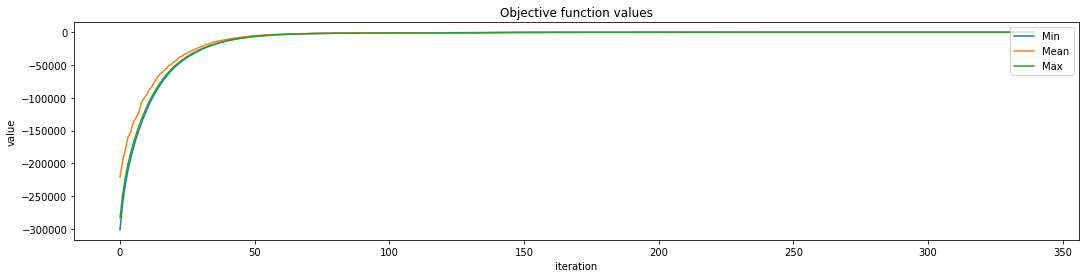

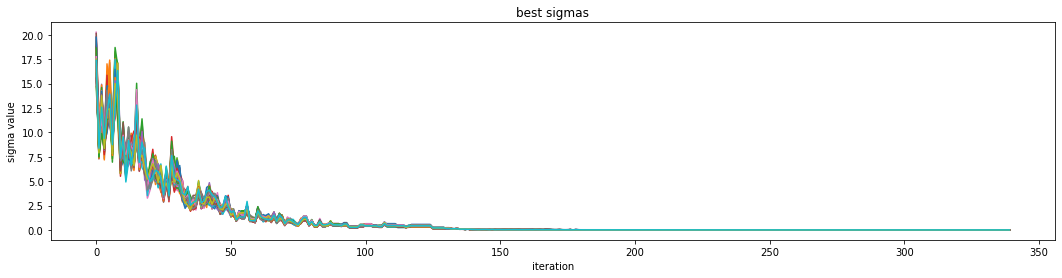

In [19]:
print("d = 100")
run_es(d=100, N=2000, T=340, objective_function=objective_function_F6, log_every=20, sigma=14)


d = 100
Iteration 0019 : best score = -45670.20633117, mean score = -53458.85458848.
Iteration 0039 : best score = -11855.52686042, mean score = -13416.80271849.
Iteration 0059 : best score = -3743.70412649, mean score = -4141.02886309.
Iteration 0079 : best score = -1721.92396216, mean score = -1928.76363984.
Iteration 0099 : best score = -1308.25601788, mean score = -1465.30060387.
Iteration 0119 : best score = -1109.72771999, mean score = -1309.15640441.
Iteration 0139 : best score = -718.48785761, mean score = -751.88758539.
Iteration 0159 : best score = -539.82299995, mean score = -551.64975960.
Iteration 0179 : best score = -476.71119676, mean score = -481.86916984.
Iteration 0199 : best score = -458.36500420, mean score = -459.40380036.
Iteration 0219 : best score = -449.68926126, mean score = -450.83672323.
Iteration 0239 : best score = -440.81721610, mean score = -441.34544310.
Iteration 0259 : best score = -439.84623804, mean score = -439.86272683.
Iteration 0279 : best score

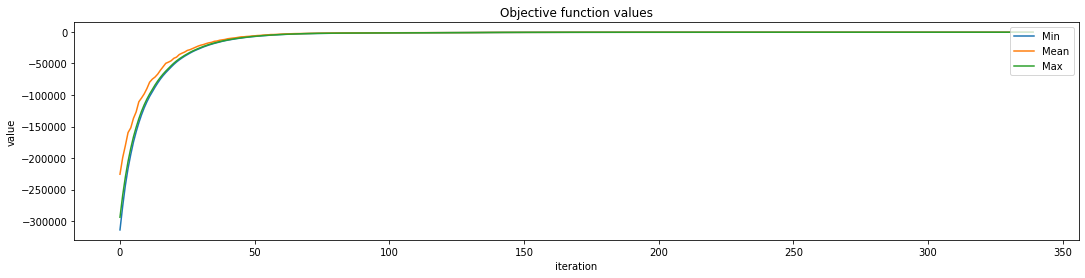

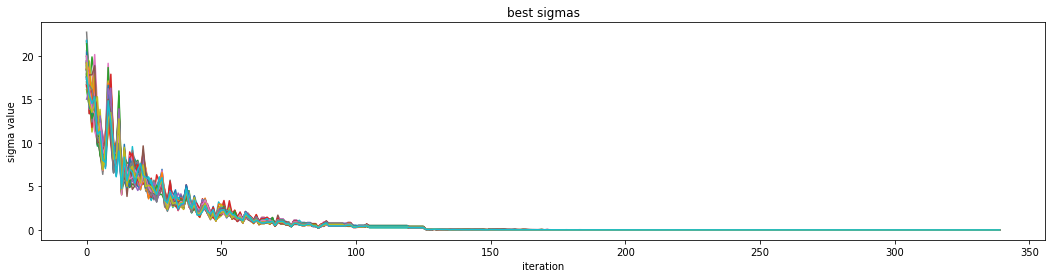

In [20]:
print("d = 100")
run_es(d=100, N=2000, T=340, objective_function=objective_function_F6,
       log_every=20, sigma=20)


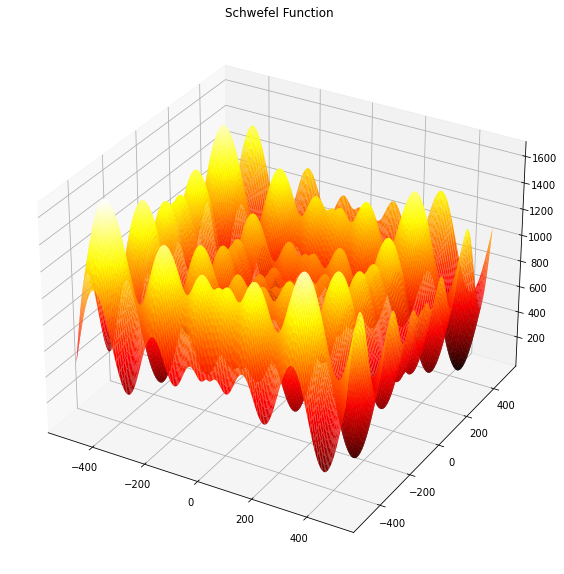

In [21]:
plot_3D_benchmark_function(objective_function_F7, np.arange(-500,
                                                            500, 5), np.arange(-500, 500, 5), 'Schwefel Function')


 d = 10
Iteration 0019 : best score = -3553.48588266, mean score = -3553.52624102.
Iteration 0039 : best score = -3553.47918055, mean score = -3553.47918091.
Iteration 0059 : best score = -3553.47918048, mean score = -3553.47918048.
Iteration 0079 : best score = -3553.47918048, mean score = -3553.47918048.
Iteration 0099 : best score = -3553.47918048, mean score = -3553.47918048.


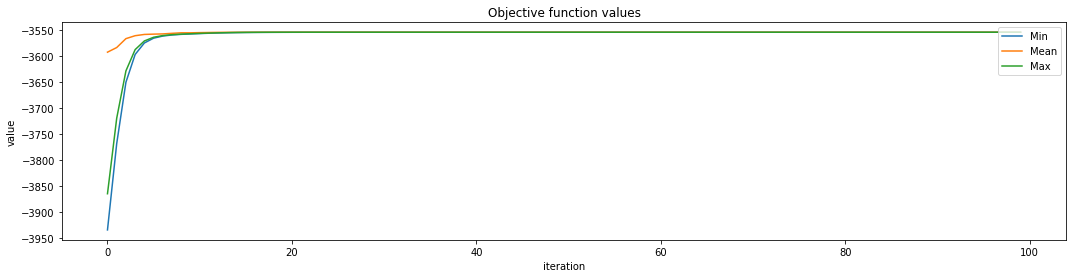

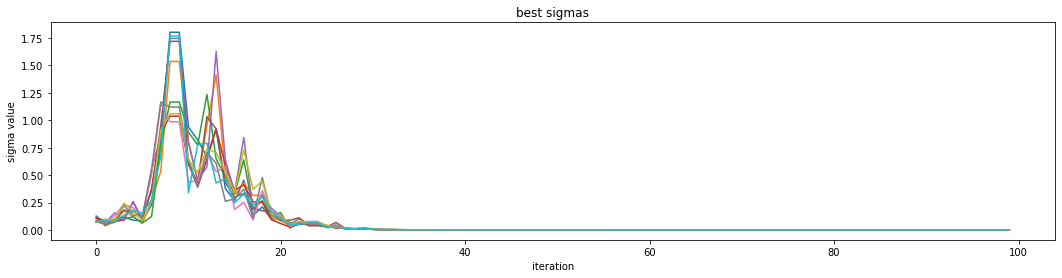

In [22]:
print(" d = 10")
run_es(d=10, N=5000, T=100, objective_function=objective_function_F7,
       log_every=20, sigma=0.1)


 d = 20
Iteration 0019 : best score = -7107.42054117, mean score = -7108.18300120.
Iteration 0039 : best score = -7106.95877259, mean score = -7106.95960653.
Iteration 0059 : best score = -7106.95836133, mean score = -7106.95836182.
Iteration 0079 : best score = -7106.95836097, mean score = -7106.95836097.
Iteration 0099 : best score = -7106.95836097, mean score = -7106.95836097.
Iteration 0119 : best score = -7106.95836097, mean score = -7106.95836097.
Iteration 0139 : best score = -7106.95836097, mean score = -7106.95836097.
Iteration 0159 : best score = -7106.95836097, mean score = -7106.95836097.
Iteration 0179 : best score = -7106.95836097, mean score = -7106.95836097.
Iteration 0199 : best score = -7106.95836097, mean score = -7106.95836097.


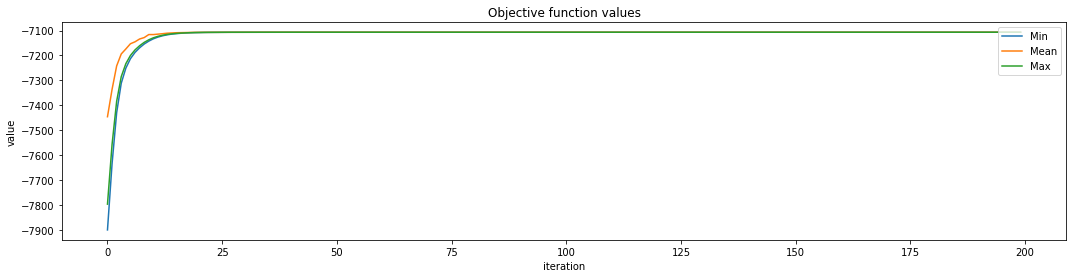

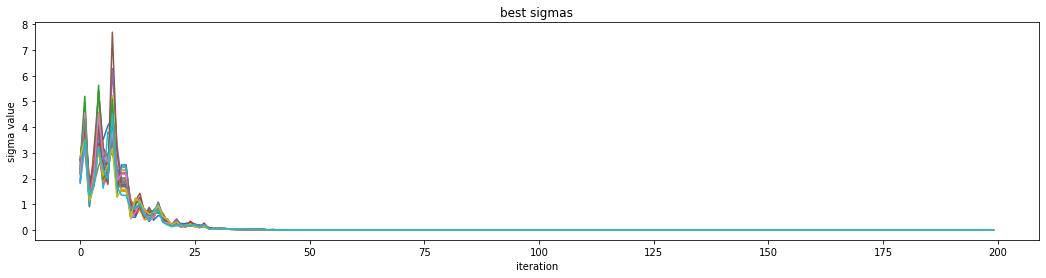

In [23]:
print(" d = 20")
run_es(d=20, N=2000, T=200, objective_function=objective_function_F7,
       log_every=20, sigma=2)


 d = 50
Iteration 0019 : best score = -17822.13570806, mean score = -17846.95684917.
Iteration 0039 : best score = -17770.16359522, mean score = -17771.69798419.
Iteration 0059 : best score = -17767.55316294, mean score = -17767.61219719.
Iteration 0079 : best score = -17767.40401394, mean score = -17767.40701545.
Iteration 0099 : best score = -17767.39640341, mean score = -17767.39655957.
Iteration 0119 : best score = -17767.39593103, mean score = -17767.39594098.
Iteration 0139 : best score = -17767.39590389, mean score = -17767.39590451.
Iteration 0159 : best score = -17767.39590252, mean score = -17767.39590255.
Iteration 0179 : best score = -17767.39590243, mean score = -17767.39590243.
Iteration 0199 : best score = -17767.39590242, mean score = -17767.39590242.


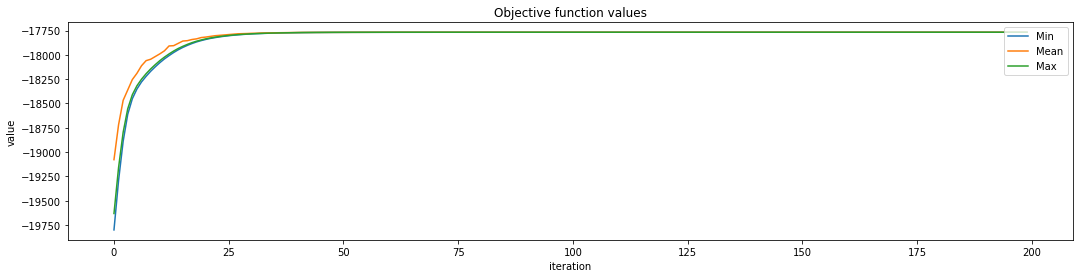

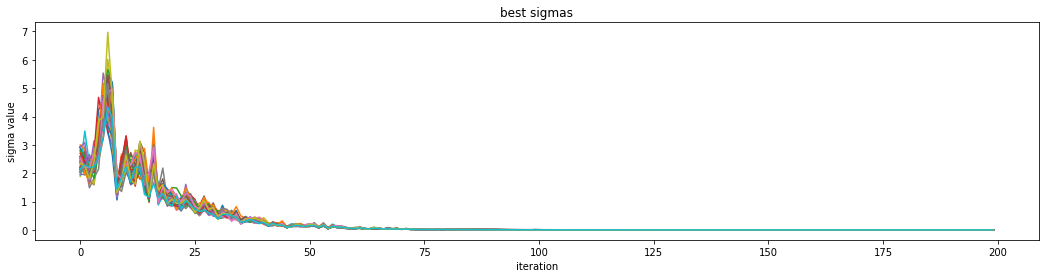

In [24]:
print(" d = 50")
run_es(d=50, N=2000, T=200, objective_function=objective_function_F7,
       log_every=20, sigma=2)


 d = 100
Iteration 0019 : best score = -35896.73163845, mean score = -35970.41978613.
Iteration 0039 : best score = -35612.16791660, mean score = -35625.88979958.
Iteration 0059 : best score = -35552.16925113, mean score = -35554.87665470.
Iteration 0079 : best score = -35538.65430056, mean score = -35539.34769880.
Iteration 0099 : best score = -35535.64270609, mean score = -35535.82778814.
Iteration 0119 : best score = -35534.99460212, mean score = -35535.03089049.
Iteration 0139 : best score = -35534.84544147, mean score = -35534.85328584.
Iteration 0159 : best score = -35534.80647542, mean score = -35534.80856750.
Iteration 0179 : best score = -35534.79525440, mean score = -35534.79597618.
Iteration 0199 : best score = -35534.79270072, mean score = -35534.79289148.


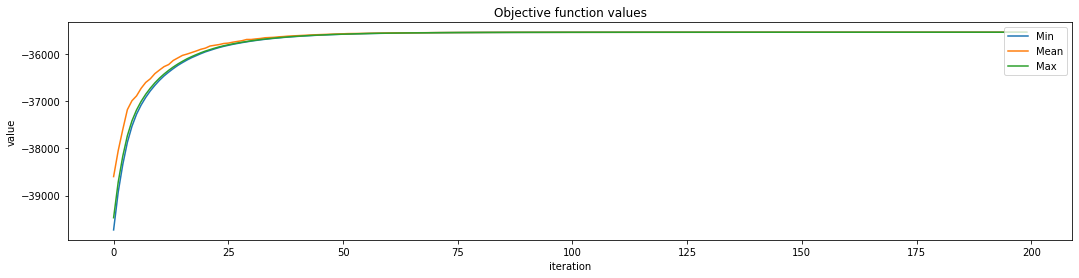

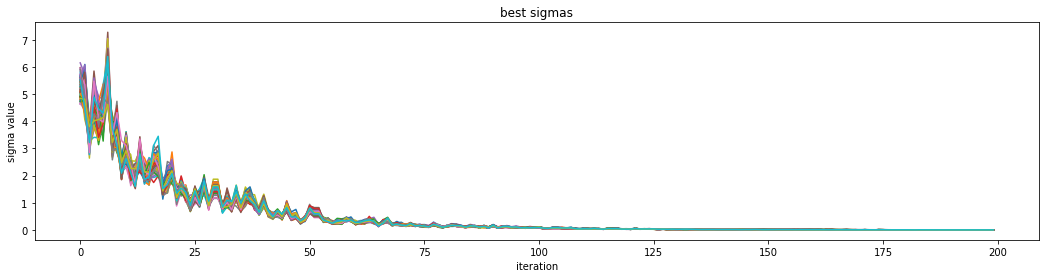

In [25]:
print(" d = 100")
run_es(d=100, N=2000, T=200, objective_function=objective_function_F7,
       log_every=20, sigma=6)


# Griewank

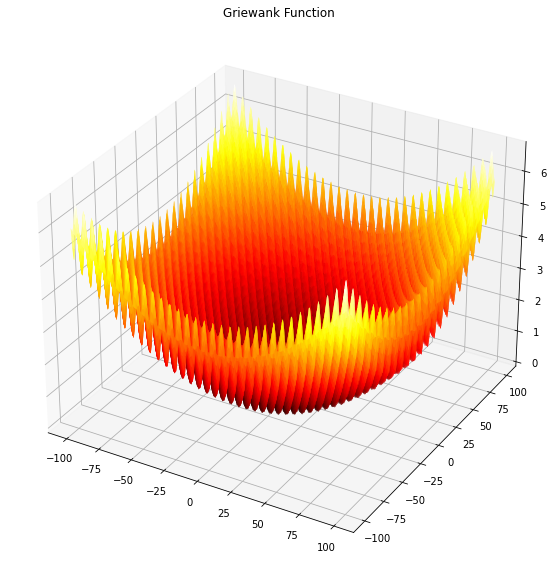

In [26]:
plot_3D_benchmark_function(objective_function_F8, np.arange(-100,
                                                            100, 0.5), np.arange(-100, 100, 0.5), 'Griewank Function')


 d = 10
Iteration 0019 : best score = -0.27193577, mean score = -0.95157281.
Iteration 0039 : best score = -0.00008792, mean score = -0.00044744.
Iteration 0059 : best score = -0.00000000, mean score = -0.00000001.
Iteration 0079 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0099 : best score = 0.00000000, mean score = 0.00000000.


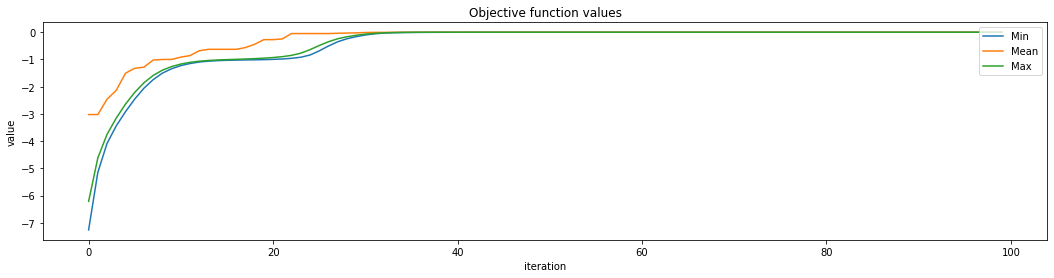

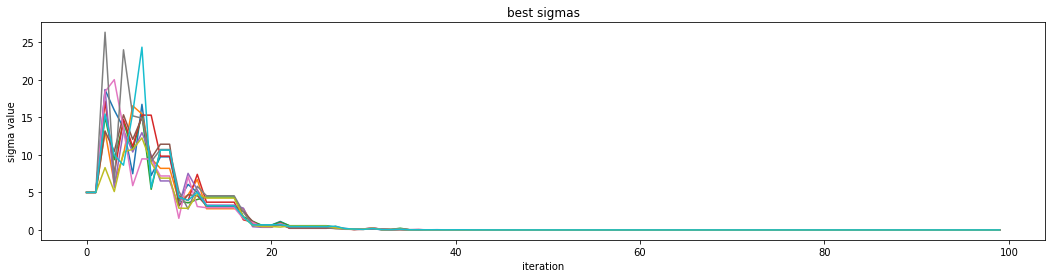

In [27]:
print(" d = 10")
run_es(d=10, N=2000, T=100, objective_function=objective_function_F8,
       log_every=20, sigma=5)


 d = 20
Iteration 0019 : best score = -1.03187401, mean score = -1.07268909.
Iteration 0039 : best score = -0.02399908, mean score = -0.04609182.
Iteration 0059 : best score = -0.00035340, mean score = -0.00078693.
Iteration 0079 : best score = -0.00000145, mean score = -0.00000437.
Iteration 0099 : best score = -0.00000000, mean score = -0.00000001.


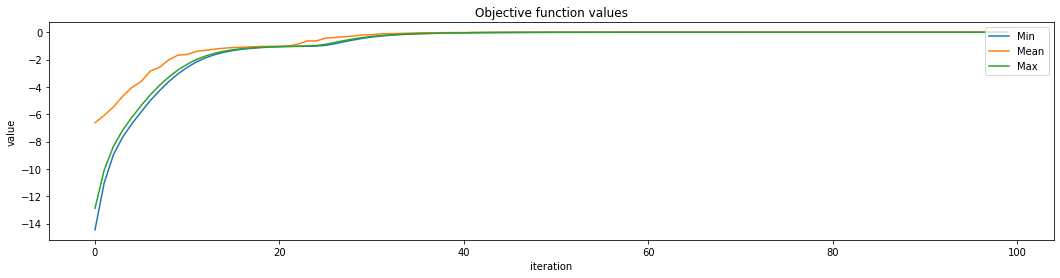

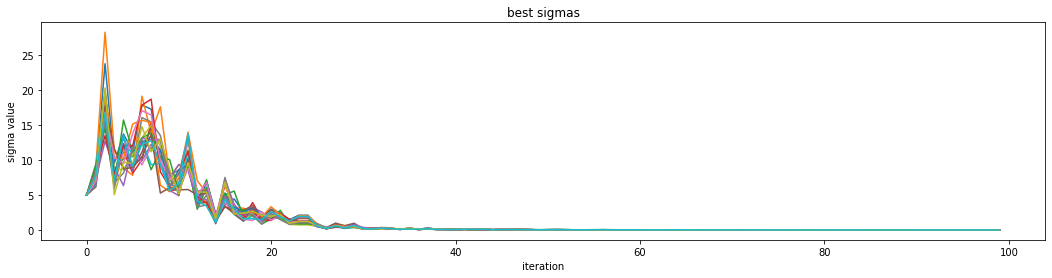

In [28]:
print(" d = 20")
run_es(d=20, N=2000, T=100, objective_function=objective_function_F8,
       log_every=20, sigma=5)


 d = 50
Iteration 0019 : best score = -2.86462215, mean score = -3.56494538.
Iteration 0039 : best score = -1.09152669, mean score = -1.13093322.
Iteration 0059 : best score = -0.47083565, mean score = -0.57534009.
Iteration 0079 : best score = -0.10706388, mean score = -0.12797522.
Iteration 0099 : best score = -0.03175505, mean score = -0.03591379.


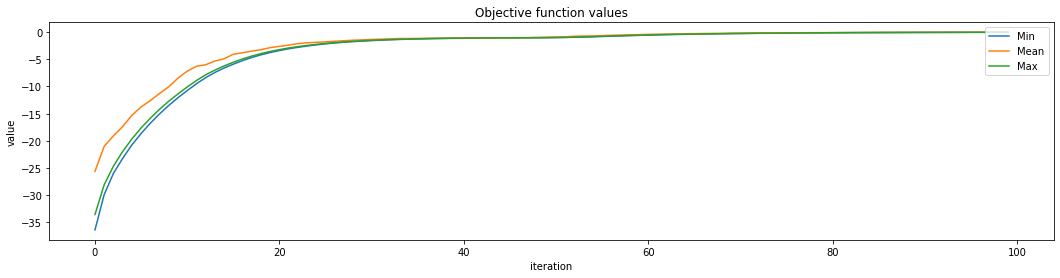

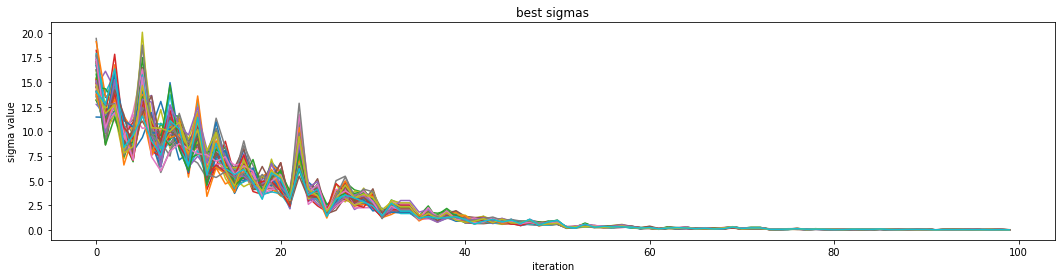

In [29]:
print(" d = 50")
run_es(d=50, N=2000, T=100, objective_function=objective_function_F8,
       log_every=20, sigma=10)


 d = 100
Iteration 0019 : best score = -11.45348333, mean score = -13.27503528.
Iteration 0039 : best score = -3.16810263, mean score = -3.64519282.
Iteration 0059 : best score = -1.50902618, mean score = -1.59728768.
Iteration 0079 : best score = -1.12812652, mean score = -1.14557348.
Iteration 0099 : best score = -0.88257505, mean score = -0.93731931.
Iteration 0119 : best score = -0.49700086, mean score = -0.52946523.
Iteration 0139 : best score = -0.30448189, mean score = -0.32685051.
Iteration 0159 : best score = -0.19315450, mean score = -0.20259706.
Iteration 0179 : best score = -0.12299461, mean score = -0.13066667.
Iteration 0199 : best score = -0.07889582, mean score = -0.08291450.


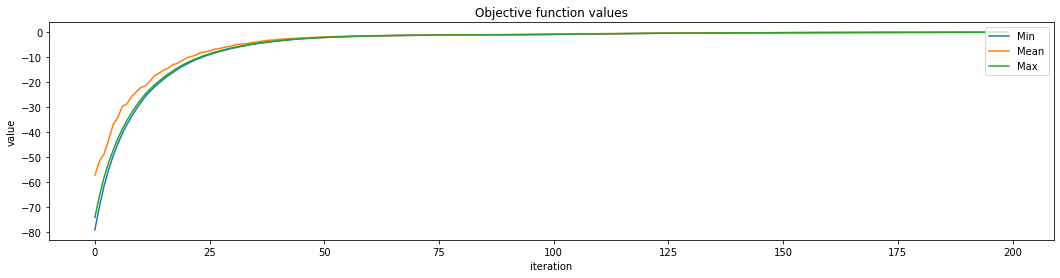

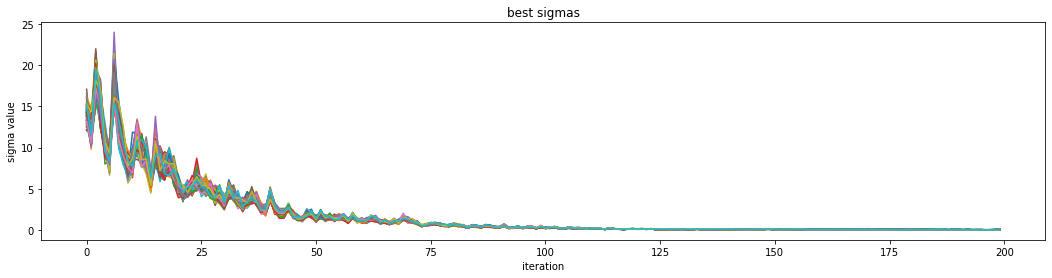

In [30]:
print(" d = 100")
run_es(d=100, N=2000, T=200, objective_function=objective_function_F8,
       log_every=20, sigma=20)
